# CSM Assignment 2 : Hands-on exercise on Twitter data

# Part 1

In the first part of the assignment, I was somewhat unclear if I should have sample the tweets that are simply containing the given substrings'#coronavirus', 'covid-19','covid19', or the tweets that are queried through hashtag search. 

For example, if a tweet is quoting another tweet that contains a hashtag '#covid19', without adding any hashtag by its own, it appears to have '#covid19' in the tweet content, but it is not queried through hashtag search in Tweeter web page. 

After discussing this matter with Trung, I concluded that in this assignment requires the 'tagged' tweets. Eventually, it took longer to retrive 3000 samples (and I failed to collect all 3000 tweets for the second sample.) Nevertheless, when I tested with a portion of the first sample, the distribution was similar to that of the full sample. Thus, I am assuming that the second analsys is representative enough, even with the small size of the dataset.

In [91]:
from __future__ import unicode_literals
# https://github.com/sixohsix/twitter/tree/master
# Python Twitter Tool (Version 1.18.0)
from twitter import *
from twitter.stream import TwitterStream, Timeout, HeartbeatTimeout, Hangup
import time
import json 
import pandas as pd
import matplotlib.pyplot as plt

# Replace with your own key/secret
consumer_key = 'vIOGhMcbFg2XEuJpyKcrC7B7Y'
consumer_secret = 'eaiyXMuu5ldacvZEqGm3mCfVk2zZEDpG89kLMQjDZjULlQl2cl'
resource_owner_key = '1242796426456956929-FSSHdfB9rO73Q8ZYxHjI457f0aCLCb'
resource_owner_secret = 'g9VtkAxwnx44v4ga9xdx14Szs0XwggvMqe67tD6xH7454'

In [72]:
# sample 1
# non geo-localized hashtag tweets

tweet_df1 = pd.DataFrame(columns=['id','text','user','quoted_status','retweeted_status','place','entities','lang','timestamp_ms'])

not_satisfied = True
count = 0
while not_satisfied:
    try:
        # When using twitter stream you must authorize.
        auth = OAuth(
            consumer_key=consumer_key,
            consumer_secret=consumer_secret,
            token=resource_owner_key,
            token_secret=resource_owner_secret
        )
        # Set track filter
        query_args = {'track': '#covid19,#covid-19,#coronavirus', 'stall_warnings':True}

        # Start authorization and filtering tweets
        stream = TwitterStream(auth=auth)
        tweet_iter = stream.statuses.filter(**query_args)


    # Iterate over the sample stream.
        for tweet in tweet_iter:

            # We should check the type of tweet. It might be  a delete or data message.
            if tweet is None:
                print("-- None --")
            elif tweet is Timeout:
                print("-- Timeout --")
            elif tweet is HeartbeatTimeout:
                print("-- Heartbeat Timeout --")
            elif tweet is Hangup:
                print("-- Hangup --")
            else:
                if 'entities' in tweet.keys():
                    hashtag_list = list(map(lambda x: x['text'].lower(),tweet['entities']['hashtags']))

                    if len(set(hashtag_list).intersection({'covid19','covid-19','coronavirus'})) > 0:
                        tweet_df1.at[count] = tweet
                        count += 1
                        if count == 3000:
                            not_satisfied = False
                            break


    except Exception as e:
        if str(e) == "'entities'":
            print('entities error: so far {0} tweets retrieved'.format(count))
            
        else:
            print('error (Follow): ' + str(e))
        
        time.sleep(15)

tweet_df1.to_csv('sample1.csv')

In [ ]:
# sample 2
# geo-localized tweets

tweet_df2 = pd.DataFrame(columns=['id','text','user','quoted_status','retweeted_status','place','entities','lang','timestamp_ms'])
not_satisfied = True
count = 0
while not_satisfied:
    try:
        # When using twitter stream you must authorize.
        auth = OAuth(
            consumer_key=consumer_key,
            consumer_secret=consumer_secret,
            token=resource_owner_key,
            token_secret=resource_owner_secret
        )
        # Set location bounding box
        query_args = {'locations':'5.9559113,45.817994999999996,10.4922941,47.8084648','stall_warnings':True}
        # Start authorization and filtering tweets
        stream = TwitterStream(auth=auth)
        tweet_iter = stream.statuses.filter(**query_args)


    # Iterate over the sample stream.
        for tweet in tweet_iter:

            # We should check the type of tweet. It might be  a delete or data message.
            if tweet is None:
                print("-- None --")
            elif tweet is Timeout:
                print("-- Timeout --")
            elif tweet is HeartbeatTimeout:
                print("-- Heartbeat Timeout --")
            elif tweet is Hangup:
                print("-- Hangup --")
            else:
                print('geo boundary: ', tweet['text'])
                if 'entities' in tweet.keys():
                    hashtag_list = list(map(lambda x: x['text'].lower(),tweet['entities']['hashtags']))

                    if len(set(hashtag_list).intersection({'covid19','covid-19','coronavirus'})) > 0:
                        tweet_df2.at[count] = tweet
                        count += 1
                        print(count, tweet['text'])
                        
                        if count % 50 == 0:
                            print('tweet retrieved: {0}'.format(count))
                        
                        if count == 10:
                            not_satisfied = False
                            break

    except Exception as e:
        print('error (Follow): ' + str(e))
        # Let your application sleep in short time
        time.sleep(15)
        
tweet_df2.to_csv('sample2.csv')

In [312]:
# load the saved csv files
import ast

tweet_df1 = pd.read_csv('sample1.csv')
tweet_df2 = pd.read_csv('sample2.csv')


In [357]:
def display_analysis1(df):

    # urls, retweets and quotes
    
    print('\n======= urls, retweets and quotes =======')
    
    urls = df[df.entities.apply(lambda x: ast.literal_eval(x)['urls']!=[])].shape[0]
    retweet = df[~df.retweeted_status.isna()].shape[0]
    quote = df[~df.quoted_status.isna()].shape[0]
    print('{:.2f}% of retrived tweets are containing urls'.format(urls*100/df.shape[0]))
    print('{:.2f}% of retrieved tweets are retweets/containing retweets'.format(100 * retweet/df.shape[0]))
    print('{:.2f}% of retrieved tweets are quoting other tweets'.format(100 * quote/ df.shape[0]))


    # language distribution
    print('\n======= language distribution =======')
    df.lang.value_counts().plot(kind='bar', figsize=(20,5))
    plt.xticks(rotation=0)
    plt.show()
    print(df.lang.value_counts().head()*100/df.shape[0])


    
    # 20 most frequent hashtags
    print('\n======= most frequent hashtags =======')
    hashtags_rank = df.entities.apply(lambda x: list(map(lambda y: y['text'].lower(), ast.literal_eval(x)['hashtags']))).explode().\
                                            value_counts().reset_index()
    hashtags_rank.index = range(1,hashtags_rank.shape[0] + 1)
    hashtags_rank = hashtags_rank.rename(columns={'index':'hashtag','entities':'frequency'})
    print(hashtags_rank.head(20))

        # distribution of the number of hashtags per tweet
    print('\n======= the number of hashtags per tweet =======')
    hashtags = df.entities.apply(lambda x: list(map(lambda y: y['text'].lower(), ast.literal_eval(x)['hashtags'])))
    print(hashtags.apply(lambda x: len(x)).value_counts())



======= urls, retweets and quotes =======
17.47% of retrived tweets are containing urls
82.00% of retrieved tweets are retweets/containing retweets
7.77% of retrieved tweets are quoting other tweets

======= language distribution =======


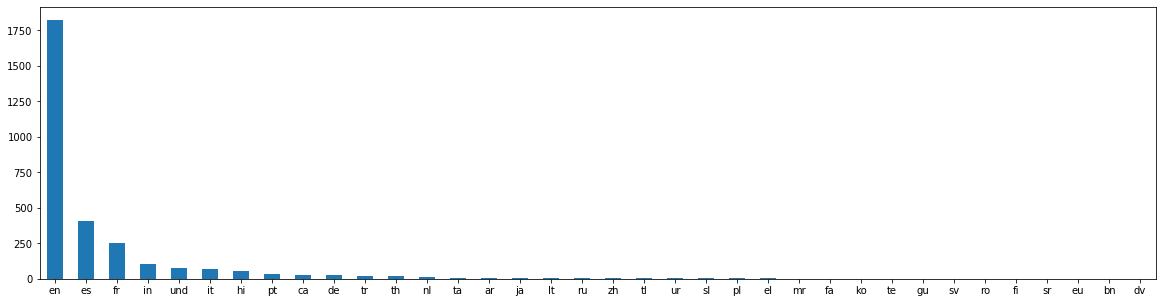

en     60.800000
es     13.533333
fr      8.466667
in      3.433333
und     2.533333
Name: lang, dtype: float64

======= most frequent hashtags =======
             hashtag  frequency
1            covid19       1813
2        coronavirus       1348
3           covid_19         88
4              china         38
5           lockdown         31
6   coronavirustruth         26
7           stayhome         24
8            moselle         20
9                nyc         20
10          covidー19         17
11             wuhan         15
12       confinement         15
13          breaking         15
14        quarantine         15
15             covid         14
16     arcelormittal         12
17          pandemic         11
18            corona         11
19             italy         10
20     quedateencasa          9

======= the number of hashtags per tweet =======
1     1785
2      707
3      299
4      105
5       59
6       21
9        8
7        8
8        6
12       1
10       1
Name:

In [354]:
# the first sample - general
display_analysis1(tweet_df1)


======= urls, retweets and quotes =======
60.36% of retrived tweets are containing urls
0.00% of retrieved tweets are retweets/containing retweets
17.12% of retrieved tweets are quoting other tweets

======= language distribution =======


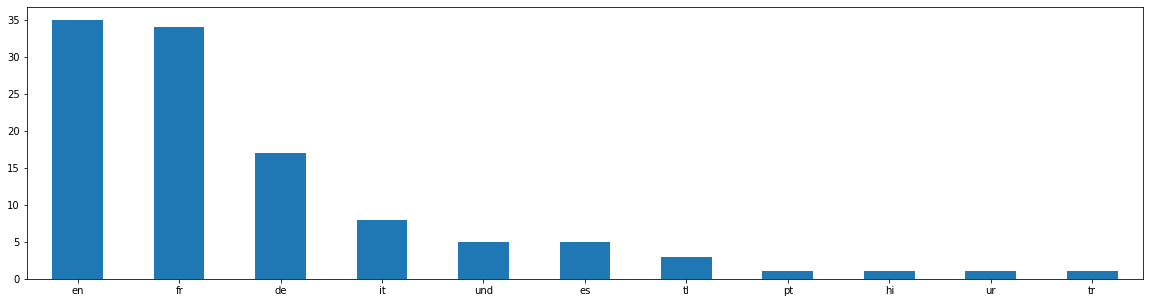

en     31.531532
fr     30.630631
de     15.315315
it      7.207207
und     4.504505
Name: lang, dtype: float64

======= most frequent hashtags =======
              hashtag  frequency
1             covid19         83
2         coronavirus         41
3          stayathome          7
4         confinement          6
5            covid_19          4
6      restezchezvous          4
7   macrondestitution          3
8              corona          3
9   confinementjour15          3
10             thonon          3
11              italy          3
12      covid19italia          3
13   coronvirusitalia          2
14           cameroun          2
15        coronakrise          2
16        sativaction          2
17           chablais          2
18          nocomment          2
19       iorestoacasa          2
20           mulhouse          2

======= the number of hashtags per tweet =======
1    38
3    25
2    21
5    10
4    10
6     4
7     2
9     1
Name: entities, dtype: int64


In [358]:
# the second sample - geo-localized. ***WARNING : the size of the dataset is 111, not 3000. 
display_analysis1(tweet_df2)

## Discussion

1. It took less than an hour to retrieve 3000 tweets of sample 1, and more and entire day to retrieve 111 tweets of sample 2.

2. In the sample 1, more than 80 percent of tweets are retweets of others. On the contrary, in the second sample, no retweets were found. Similarily, the percentage of tweets containing urls and quoting other tweets differs greatly between the two samples. Right now I have no concrete guess towards the finding, but I am weakly assuming that Twitter is not a major social media in Switzerland, and how Twitter users behave differs a lot by the geographical region.

3. Generally, English, followed by Spanish and French, is notably the most powerful language in non geo-localized Twitter world. This is no surprise, since majority of online data is in English as well. This also corresponds to my previous knowledge on language divide on web and social media. In the second sample, geo-localized in Switzerland, showed greater significance in French, German, and Italian. This is again no surprise, since those are the official langauges of Switzerland. It was unexpected, though, that the portion of english tweets is still the highest in Switzerland, whereas the portion of German, the language with the largest popularity in Switzerland, is close to half of that of English or French. 

3. In the first sample, a majority of top 20 hashtags are in english. Also, most of them (china, lockdown, stayhome, wuhan, confinement, etc) are somehow related to current COVID19 crisis as well. More than half of the tweets are referring to a single hashtag. In the second sample, there are more top hashtags in French rather than English. Moreover, hashtags that are related to Italy is more significant in the second case. Considering the geographical closeness of Switzerland and Italy, it is reasonable to conclude that people in Switzerland are more concerned about the situation in Italy.


# Part 2

## How I selected handles 
In order to choose the media/NGO/goverenment handles, I searched the given hashtags in the Tweeter web page, and looked for the 'verified' accounts. However, I found out that surprisingly few media channel accounts are tweeting with the hashtags. For example, New York Times(@nytimes) is tweeting a lot about the coronavirus pandemic, and the tweet contents contain the word 'coronavirus'. But they are not included in my query because it is not 'tagging' its tweets (in short, no #coronavirus hashtag)

This is related to the ambiguity I faced in the first part of the assignment. In the end, I sticked to the 'hashtag entity' of tweets and chose the accounts that tweets with the tags. As a result, some of the very well-known accounts (e.g, @realDonalTrump, @cnn, etc) seem to be replaced by some unfamiliar media/NGO/government officials accounts(e.g, @sbs8news, @quicktake). With different problem definitions, the result could have been quite different from what I found out here.

In [271]:
# list of 20 media organizations
media_dict = {
    'skynews':7587032,
    'quicktake':252751061,
    'ani':355989081,
    'lbcnews':2329058035,
    'ajenglish':4970411,
    
    'bbcspotlight':89226120,
    'gulfnews':20578408,
    'sbs8news':91946403,
    'hartfordcourant':14708814,
    'huffpost':14511951,
    
    'nytimes':807095,
    'techreview':15808647,
    'nbcnews':14173315,
    'foxnews':1367531,
    'reuters':1652541,
    
    'theeconomist':5988062,
    'laliberte':361936611,
    'bbcafrica':36670025,
    'washingtonpost':2467791,
    'thecableng':1954402777,
}


# list of 20 NGO or goverenment officials
ngo_gov_dict = {
    'who':14499829,
    'pahoemergencies':103067293,
    'cdcgov':146569971,
    'whonigeria':846724193345527808,
    'Minsa_Peru':138471254,
    
    'Defensagob':274035504,
    'iran_policy':1073802444,
    'HouseDemocrats':43963249,
    'GHS':201421060,
    '@un':14159148,

    '@Refugees':14361155,
    '@UN_Women':17137628,
    '@UNESCO':20646711,
    '@WFP':27830610,
    '@wef':5120691,

    'WorldBank':27860681,
    'IMFNews':25098482,
    'EU_Commission':157981564,
    'BAG_OFSP_UFSP':326650532,
    'OECD':25390350
}

In [375]:
def tweeted(df, dic):
    return df[df.user.apply(lambda x: ast.literal_eval(x)['id'] in dic.values())]

def retweeted(df, dic):
    retweeted_df = df[~df.retweeted_status.isna()]
    return retweeted_df[retweeted_df.retweeted_status.apply(lambda x: ast.literal_eval(x)['user']['id'] in dic.values())]


print('{:.2f}% of retrieved tweets are directly tweeted by selected media handles'.\
      format(tweeted(tweet_df1, media_dict).shape[0]*100/tweet_df1.shape[0]))
print('{:.2f}% of retrieved tweets are directly tweeted by selected ngo/gov handles'.\
      format(tweeted(tweet_df1, ngo_gov_dict).shape[0]*100/tweet_df1.shape[0]))

print('{:.2f}% of retrieved tweets are retweets of selected media handles'.\
      format(retweeted(tweet_df1, media_dict).shape[0]*100/tweet_df1.shape[0]))
print('{:.2f}% of retrieved tweets are retweets of selected ngo/gov handles'.\
      format(retweeted(tweet_df1, ngo_gov_dict).shape[0]*100/tweet_df1.shape[0]))

0.00% of retrieved tweets are directly tweeted by selected media handles
0.00% of retrieved tweets are directly tweeted by selected ngo/gov handles
2.43% of retrieved tweets are retweets of selected media handles
0.80% of retrieved tweets are retweets of selected ngo/gov handles


In [384]:
print('====== media handles that appear in the sample ======')
print(retweeted(tweet_df1, media_dict).retweeted_status.apply(lambda x: ast.literal_eval(x)['user']['name']).value_counts())

====== media handles that appear in the sample ======
ANI                       65
QuickTake by Bloomberg     3
Al Jazeera English         2
TheCable                   2
Sky News                   1
Name: retweeted_status, dtype: int64


In [383]:
print('====== ngo/gov. handles that appear in the sample ======')
print(retweeted(tweet_df1, ngo_gov_dict).retweeted_status.apply(lambda x: ast.literal_eval(x)['user']['name']).value_counts())

====== ngo/gov. handles that appear in the sample ======
World Health Organization (WHO)    15
CDC                                 8
Ministerio de Salud                 1
Name: retweeted_status, dtype: int64


## Discussion

In the sample, none of the tweets were produced directly by the selected media/NGO/goverenment handles. The portion of the tweets generated by the 40 accounts that appear as 'retweets' is slightly higher. This corresponds to my knowledge in tweeting experience, that tweets generated by those powerful, official accounts are not substantial in number. However, the influence of those tweets appears to be very weak. This might be related to the selection of channels. To prove this, the same operation should be taken with a different collection. 

According to the sample, tweets of the media accounts are retweeted more than three times than that of ngo/government officials accounts. In the media channel handles, no tweets/retweets from the most famous channels (nytimes, etc) were found. This is partially due to the matter mentioned at the beginning of this part: those media are not tweeting with hashtags at the first place. Among the NGO/gov. handles, WHO was the most retweeted. This is understandable, because in time like this, updates from WHO are working as reliable news in itself.

With different rules in retrieving tweets or criteria in selecting media/ngo/gov. handles, the figure could have differed a lot. 